# Simulate LFP Correlation

This notebook...

NOTE: LFP data has not been attached to spontaneous blocks

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import neo
from neurodsp.sim.transients import sim_synaptic_kernel
from specparam import SpectralModel
import elephant.conversion as conv
import quantities as pq

import sys
sys.path.append("../../allen_vc")
from analysis import compute_psd

print("Packages Imported!")

Packages Imported!


## Settings

In [67]:
# paths
PROJECT_PATH = 'D:/visual_encoding'
STIM_CODE = 'natural_movie_one_more_repeats'

# spectra
FS = 1250
N_JOBS = -1
F_MIN = 2
F_MAX = 200
BANDWIDTH = 1

#specparam
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [2, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0, # (default: 0) 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2, # (default: 2.0)
    'aperiodic_mode'    :   'knee',
    'verbose'           :   False}

## Load Data

Code below is soley for testing/observation

In [14]:
# load blocks, store data

for i, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    
    block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    
    lfp_block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    
    break

In [15]:
block.segments[0]

Segment with 3 analogsignals, 50 spiketrains
annotations: {'stimulus_onset': 2290.491439954788,
  'time_window': array([ 0, 30]),
  'running': False}
# analogsignals (N=3)
0: AnalogSignal with 1 channels of length 1500; units cm/s; datatype float64 
   name: 'running_speed'
   sampling rate: 50.0 Hz
   time: 2290.5 s to 2320.5 s
1: AnalogSignal with 1 channels of length 1500; units cm**2; datatype float64 
   name: 'pupil_area'
   sampling rate: 50.0 Hz
   time: 2290.5 s to 2320.5 s
2: AnalogSignal with 24 channels of length 37511; units uV; datatype float32 
   name: 'lfp'
   annotations: {'data_type': 'lfp',
     'probe_id': 848037572,
     'brain_structure': 'VISp',
     'channel_ids': array([867382006, 867382015, 867382023, 867382031, 867382039, 867382048,
            867382056, 867382064, 867382072, 867382080, 867382089, 867382097,
            867382105, 867382113, 867382121, 867382129, 867382137, 867382145,
            867382153, 867382161, 867382169, 867382177, 867382185, 867382

## Main

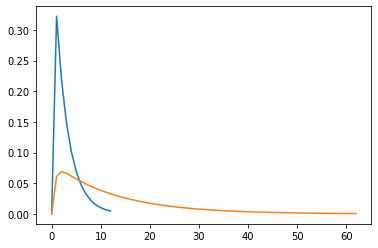

In [73]:
# create synaptic kernels based on Gao 2017

ampa = sim_synaptic_kernel(5*0.002, FS, 0.0001, 0.002)
gaba = sim_synaptic_kernel(5*0.010, FS, 0.0005, 0.010)

plt.plot(ampa)
plt.plot(gaba);

In [74]:
# load blocks

sim_lfp_data = []

for i_file, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    
    block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    session = file.split('_')[1].split('.')[0]
    
    print(f"Compute Session {session}:")
    
    block_data = []
    
    # loop through epochs
    for i_seg, seg in enumerate(block.segments):
        
        if i_seg%10 == 0:
            print(f"\t segment ({i_seg + 1}/{len(block.segments)})")
        
        # filter spikes by cell type, convert to bool array
        inhib = seg.filter(cell_type='inhibitory')
        excit = seg.filter(cell_type='excitatory')
        
        
        if len(inhib) > 0:
            inhib_bool = conv.BinnedSpikeTrain(inhib, binsize=(1/FS)*pq.s).to_bool_array()
            inhib_spikes = np.sum(inhib_bool, axis=0)
            
        else:
            inhib_spikes = np.zeros(30*FS)
            
            
        if len(excit) > 0:
            excit_bool = conv.BinnedSpikeTrain(excit, binsize=(1/FS)*pq.s).to_bool_array()
            excit_spikes = np.sum(excit_bool, axis=0)
            
        else:
            excit_spikes = np.zeros(30*FS)
            
        
        # convolve
        inhib_lfp = np.convolve(inhib_spikes, gaba, 'same') # use same to preserve dimensions with lfp
        excit_lfp = np.convolve(excit_spikes, ampa, 'same')
        
        # summate
        sim_lfp = excit_lfp - inhib_lfp
        
        # compute correlation with actual lfp
        lfp = np.array(seg.filter(name='lfp')[0])[:37500].mean(axis=1) # which channels? (for now cut extra values)
        corr = np.corrcoef(sim_lfp, lfp)[0, 1]
        
        
        # compute spectral power
        spectra, freq = compute_psd(sim_lfp, FS, fmin=F_MIN, fmax=F_MAX, bandwidth=BANDWIDTH,
                                    n_jobs=N_JOBS, verbose=False)
        
        # compute specparam metrics
        fm = SpectralModel(**SPEC_PARAM_SETTINGS)
        fm.fit(freq, spectra)
        params = fm.aperiodic_params_
        
        block_data.append(list(params) + [corr, i_seg])
        
    # create dataframe
    df = pd.DataFrame(block_data, columns=['offset', 'knee', 'exponent', 'sim_corr', 'epoch_idx'])
    df['session'] = session
    sim_lfp_data.append(df)
    
# concatenate
sim_lfp_df = pd.concat(sim_lfp_data)

# save
sim_lfp_df.to_csv(f'D:/visual_encoding/data/lfp_data/sim/sim_lfp_{STIM_CODE}.csv',index=False)

Compute Session 847657808:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 840012044:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 839068429:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 835479236:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 831882777:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)


C:\Users\User\.conda\envs\py37\lib\site-packages\elephant\utils.py:299: UserWarning: Correcting a rounding error in the calculation of the number of bins by incrementing the value by 1. You can set tolerance=None to disable this behaviour.
  warnings.warn('Correcting a rounding error in the calculation '


Compute Session 829720705:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 821695405:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 816200189:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 794812542:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 793224716:
	 segment (1/58)
	 segment (11/58)
	 segment (21/58)
	 segment (31/58)
	 segment (41/58)
	 segment (51/58)


C:\Users\User\.conda\envs\py37\lib\site-packages\elephant\utils.py:299: UserWarning: Correcting a rounding error in the calculation of the number of bins by incrementing the value by 1. You can set tolerance=None to disable this behaviour.
  warnings.warn('Correcting a rounding error in the calculation '


Compute Session 789848216:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)


C:\Users\User\.conda\envs\py37\lib\site-packages\elephant\utils.py:299: UserWarning: Correcting a rounding error in the calculation of the number of bins by incrementing the value by 1. You can set tolerance=None to disable this behaviour.
  warnings.warn('Correcting a rounding error in the calculation '


Compute Session 787025148:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)


C:\Users\User\.conda\envs\py37\lib\site-packages\elephant\utils.py:291: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '


	 segment (41/60)
	 segment (51/60)
Compute Session 786091066:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)


C:\Users\User\.conda\envs\py37\lib\site-packages\elephant\utils.py:299: UserWarning: Correcting a rounding error in the calculation of the number of bins by incrementing the value by 1. You can set tolerance=None to disable this behaviour.
  warnings.warn('Correcting a rounding error in the calculation '


Compute Session 781842082:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)


C:\Users\User\.conda\envs\py37\lib\site-packages\elephant\utils.py:299: UserWarning: Correcting a rounding error in the calculation of the number of bins by incrementing the value by 1. You can set tolerance=None to disable this behaviour.
  warnings.warn('Correcting a rounding error in the calculation '


Compute Session 779839471:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 778998620:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)


C:\Users\User\.conda\envs\py37\lib\site-packages\elephant\utils.py:299: UserWarning: Correcting a rounding error in the calculation of the number of bins by incrementing the value by 1. You can set tolerance=None to disable this behaviour.
  warnings.warn('Correcting a rounding error in the calculation '


Compute Session 778240327:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 774875821:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)


C:\Users\User\.conda\envs\py37\lib\site-packages\elephant\utils.py:299: UserWarning: Correcting a rounding error in the calculation of the number of bins by incrementing the value by 1. You can set tolerance=None to disable this behaviour.
  warnings.warn('Correcting a rounding error in the calculation '


Compute Session 771990200:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 771160300:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 768515987:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 767871931:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)
Compute Session 766640955:
	 segment (1/60)
	 segment (11/60)
	 segment (21/60)
	 segment (31/60)
	 segment (41/60)
	 segment (51/60)


C:\Users\User\.conda\envs\py37\lib\site-packages\elephant\utils.py:299: UserWarning: Correcting a rounding error in the calculation of the number of bins by incrementing the value by 1. You can set tolerance=None to disable this behaviour.
  warnings.warn('Correcting a rounding error in the calculation '


In [69]:
sim_lfp_df

,offset,knee,exponent,sim_corr,epoch_idx,session
0,1.098141,1.887216,1.005287,-0.362640,0,847657808
1,1.836286,67.316972,1.352607,-0.226779,1,847657808
2,1.367301,12.170504,1.176219,-0.319581,2,847657808
3,1.216450,2.985747,1.131720,-0.245621,3,847657808
4,2.316777,297.102542,1.565060,-0.257411,4,847657808
...,...,...,...,...,...,...
55,1.801112,84.390662,1.360062,-0.146745,55,766640955
56,2.171305,294.743971,1.526923,-0.141995,56,766640955
57,2.657057,877.770352,1.692497,-0.080646,57,766640955
58,2.430372,567.985167,1.615572,-0.094321,58,766640955


In [70]:
from scipy.stats import zscore

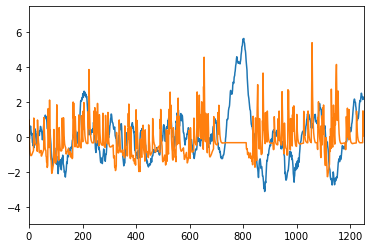

In [75]:
# plot examples with actual LFP side by side

plt.plot(zscore(lfp), label='actual')
plt.plot(zscore(sim_lfp), label='simulated')
plt.xlim([0,FS]);

Text(0.5, 1.0, 'Simulation vs. Empirical LFP Correlation')

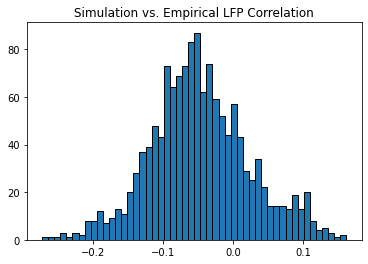

In [76]:
# plot correlation coefficient distribution

plt.hist(sim_lfp_df['sim_corr'], edgecolor='black', bins=50)
plt.title('Simulation vs. Empirical LFP Correlation')

In [ ]:
# plot specparams

# load actual params
param_df = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/{STIM_CODE}/lfp_params.csv')

for var in ['offset', 'knee', 'exponent']:
    
    plt.scatter(sim_lfp_df[var], param_df[var])
    plt.tile(var)
    plt.show()